![alt text](logo.png "Virtual Coach")
<h1><center>Virtual Coach</center></h1>

## Fitness activities round the globe

![alt text](strava.jpg "Activities around the world")

# 39.8% of our country's population are obese/at the risk of obseity
# But there is also some risk of over working out `Rhambdo` 
#### https://www.webmd.com/fitness-exercise/news/20180222/exercising-yourself-to-death-the-risk-of-rhabdo


<h1><center>Heartrate Zones</center></h1>

![alt text](zones.png "Zones")

## `Raw data -> Building data pipeline -> Insights -> Recommendations`

![alt text](intro.jpg "Virtual Coach")

# 1. Creating connections to SQL database

In [14]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [87]:
## connection functions

import os
import sqlite3
from sqlite3 import Error
import gzip
import pandas as pd
import matplotlib as plt

def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

        
    return conn

db_file = 'virtual_coach.db'

In [63]:
try:
    conn.close()
except:
    pass

In [64]:
# Creating the database
# The below code will delete the current db and recreate it
# Run with care

# db_file = 'virtual_coach.db'
# conn = create_connection(db_file, delete_db=True)
# conn.close()


In [88]:
# setting the current directory where all the activity datasets exist
%cd "C:\UB\Studies\Semester 1\Programming\virtual_coach\2. Activity Datasets"

C:\UB\Studies\Semester 1\Programming\virtual_coach\2. Activity Datasets


### 1.1 Sample dataset structure

In [ ]:
# time	activityType	lapNumber	distance	speed	calories	lat	long	elevation	heartRate	cycles
# 0	0	1	0	0	0	42.953842	-78.829602	196.5	94	0
# 1	0	1	0	0	0	42.953856	-78.829601	196.5	95	0
# 2	0	1	2.08	1.62	0	42.953868	-78.829604	196.6	95	0
# 3	0	1	3.05	1.67	0	42.95388	-78.829612	196.6	96	0
# 4	0	1	4.5	1.62	0	42.953891	-78.829625	196.6	96	0


In [66]:
# Reading all the datasets and pushing it into the table 
# creating a list of all the csv files

dataSetsPath=r"C:\UB\Studies\Semester 1\Programming\virtual_coach\2. Activity Datasets"
import random
import os
import pandas as pd
list_files=[]
directory = os.path.join(os.getcwd(),dataSetsPath)
for root,dirs,files in os.walk(directory):
    for file in files:
        if file.endswith(".csv"):
            filePath=dataSetsPath+"/"+file
            df= pd.read_csv(filePath)
            filename= file
            list_files.append(filename)
            

In [67]:
conn = create_connection(db_file, delete_db=False)
with conn:
    c = conn.cursor()
    sql='Create TABLE activities_base(Activity_id TEXT, TIME INTEGER, ACTIVITYTYPE INTEGER, LAPNUMBER INTEGER, DISTANCE REAL, SPEED REAL, CALORIES INTEGER, LAT REAL, LONG REAL, ELEVATION REAL, HEARTRATE INTEGER, CYCLES INTEGER);'
    c.execute(sql)

for file in list_files:
    activity=pd.read_csv(file)
    rows=activity.shape[0]
    for i in range(0,rows):
        packet=activity.iloc[i,].tolist()
        packet=[file]+packet
        with conn:
            c = conn.cursor()
            sql = """ INSERT INTO activities_base VALUES(?,?,?,?,?,?,?,?,?,?,?,?) """
            c.execute(sql,packet)



# 2. Checking if the data has got inserted as expected

In [14]:
conn = create_connection(db_file, delete_db=False)
with conn:
    c = conn.cursor()
    sql='select activity_id, count(*) as cnt from activities_base base group by 1;'
    c.execute(sql)
    rows=c.fetchall()
    print(rows)

[('Running_07-03-05.csv', 972), ('Running_07-10-59.csv', 6767), ('Running_07-43-57.csv', 6240), ('Running_08-12-06.csv', 1373), ('Running_08-47-01.csv', 3536), ('Running_09-51-41.csv', 1159), ('Running_09-55-32.csv', 1391), ('Running_10-15-22.csv', 60), ('Running_10-36-19.csv', 716), ('Running_10-51-40.csv', 196), ('Running_10-55-43.csv', 345), ('Running_11-01-28.csv', 10627), ('Running_11-44-18.csv', 3972), ('Running_13-17-48.csv', 125), ('Running_15-00-22.csv', 129), ('Running_16-39-48.csv', 52), ('Running_17-22-03.csv', 1559), ('Running_17-59-58.csv', 3133), ('Running_18-15-35.csv', 1079), ('Running_18-17-02.csv', 513), ('Running_18-20-02.csv', 2146), ('Running_18-26-56.csv', 3564), ('Running_18-34-29.csv', 2866), ('Running_19-11-05.csv', 1588), ('Running_19-30-16.csv', 3544), ('Running_19-38-28.csv', 1177), ('Running_19-42-30.csv', 3069), ('Running_19-42-54.csv', 2301), ('Running_19-43-36.csv', 1669), ('Running_19-46-35.csv', 858), ('Running_19-51-43.csv', 1709), ('Running_20-00-36

In [15]:
conn = create_connection(db_file, delete_db=False)
with conn:
    c = conn.cursor()
    sql='select count(*) from (select activity_id as cnt from activities_base base group by 1)x;'
    c.execute(sql)
    rows=c.fetchall()
    print(rows)

[(36,)]


In [89]:
def query_activities_db(sql):
    conn = create_connection(db_file, delete_db=False)
    with conn:
        c = conn.cursor()
        c.execute(sql)
        rows=c.fetchall()
        return(rows)


In [24]:
sql='select count(*) from (select activity_id as cnt from activities_base base group by 1)x;'
query_activities_db(sql)

[(36,)]

## 2.1 Activities and their duration

In [21]:
# During how many activities the user has stayed in zone 5?
sql="select activity_id,max(heartrate) from activities_base group by 1 order by 2 desc;"
query_activities_db(sql)

[('Running_10-51-40.csv', 192),
 ('Running_07-10-59.csv', 190),
 ('Running_09-55-32.csv', 188),
 ('Running_19-46-35.csv', 188),
 ('Running_18-34-29.csv', 185),
 ('Running_19-42-54.csv', 185),
 ('Running_19-51-43.csv', 184),
 ('Running_11-44-18.csv', 182),
 ('Running_20-00-36.csv', 181),
 ('Running_08-47-01.csv', 177),
 ('Running_07-43-57.csv', 176),
 ('Running_18-26-56.csv', 174),
 ('Running_15-00-22.csv', 172),
 ('Running_13-17-48.csv', 170),
 ('Running_17-59-58.csv', 170),
 ('Running_19-42-30.csv', 170),
 ('Running_08-12-06.csv', 169),
 ('Running_18-20-02.csv', 169),
 ('Running_20-20-04.csv', 168),
 ('Running_10-36-19.csv', 167),
 ('Running_09-51-41.csv', 165),
 ('Running_19-43-36.csv', 165),
 ('Running_19-30-16.csv', 164),
 ('Running_20-09-27.csv', 164),
 ('Running_21-06-52.csv', 163),
 ('Running_20-24-47.csv', 162),
 ('Running_10-55-43.csv', 161),
 ('Running_17-22-03.csv', 159),
 ('Running_19-38-28.csv', 159),
 ('Running_19-11-05.csv', 158),
 ('Running_07-03-05.csv', 155),
 ('Runni

In [22]:
# activities where the user has stayed in zone 5 for more than 10 seconds 

sql="select activity_id, sum(zone_5_flag) as time_spend_in_zone_5 from (select activity_id,case when heartrate>179 then 1 else 0 end as zone_5_flag from activities_base)x group by 1 order by 2 desc;"
query_activities_db(sql)

[('Running_07-10-59.csv', 123),
 ('Running_19-46-35.csv', 95),
 ('Running_10-51-40.csv', 89),
 ('Running_19-51-43.csv', 54),
 ('Running_18-34-29.csv', 46),
 ('Running_19-42-54.csv', 42),
 ('Running_09-55-32.csv', 13),
 ('Running_11-44-18.csv', 10),
 ('Running_20-00-36.csv', 6),
 ('Running_07-03-05.csv', 0),
 ('Running_07-43-57.csv', 0),
 ('Running_08-12-06.csv', 0),
 ('Running_08-47-01.csv', 0),
 ('Running_09-51-41.csv', 0),
 ('Running_10-15-22.csv', 0),
 ('Running_10-36-19.csv', 0),
 ('Running_10-55-43.csv', 0),
 ('Running_11-01-28.csv', 0),
 ('Running_13-17-48.csv', 0),
 ('Running_15-00-22.csv', 0),
 ('Running_16-39-48.csv', 0),
 ('Running_17-22-03.csv', 0),
 ('Running_17-59-58.csv', 0),
 ('Running_18-15-35.csv', 0),
 ('Running_18-17-02.csv', 0),
 ('Running_18-20-02.csv', 0),
 ('Running_18-26-56.csv', 0),
 ('Running_19-11-05.csv', 0),
 ('Running_19-30-16.csv', 0),
 ('Running_19-38-28.csv', 0),
 ('Running_19-42-30.csv', 0),
 ('Running_19-43-36.csv', 0),
 ('Running_20-09-27.csv', 0),
 

In [90]:
# creating a list of activities where the user has stayed in zone 5 for more than 10 seconds

sql="select activity_id, sum(zone_5_flag) as time_spend_in_zone_5 from (select activity_id,case when heartrate>179 then 1 else 0 end as zone_5_flag from activities_base)x group by 1 having sum(zone_5_flag)>9 order by 2 desc;"
zone_5_list=query_activities_db(sql)

## 2.2 List where the user has stayed in zone 5 for long
`This list can be used for model training and validation` 

In [26]:
# creating a list of the activities that are important for model train and validation
zone_5_filenames=[]
for i in zone_5_list:
    zone_5_filenames=zone_5_filenames+[i[0]]
    
zone_5_filenames

['Running_07-10-59.csv',
 'Running_19-46-35.csv',
 'Running_10-51-40.csv',
 'Running_19-51-43.csv',
 'Running_18-34-29.csv',
 'Running_19-42-54.csv',
 'Running_09-55-32.csv',
 'Running_11-44-18.csv']

In [ ]:
# creating another table with zone mapping

sql="create table activities_base_with_zone as select *, case when heartrate>179 then 5 when heartrate>159 then 4 when heartrate>139 then 3 when heartrate>119 then 2 when heartrate>99 then 1 else 0 end as zone from activities_base;"
query_activities_db(sql)


In [29]:
sql = 'select zone, count(*) from activities_base_with_zone group by 1;'
query_activities_db(sql)

[(0, 10545), (1, 15385), (2, 14858), (3, 24482), (4, 8499), (5, 478)]

In [35]:
sql="select zone, avg(first_zone) as avg_time from (select activity_id, zone, min(time) as first_zone from activities_base_with_zone group by 1,2)x where zone>2 group by 1;"
time_taken=query_activities_db(sql)

# 3. How long every athlete warmsup?

Checking `the time taken during an activity` before a particular zone is reached

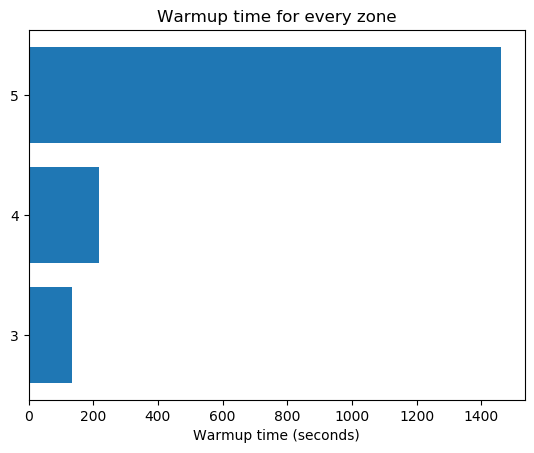

In [84]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

zones=[]
for i in time_taken:
    zones=zones+[i[0]]

y_pos = np.arange(len(zones))

warmup_time=[]
for i in time_taken:
    warmup_time=warmup_time+[i[1]]
    
plt.barh(y_pos, warmup_time, align='center', alpha=1)
plt.yticks(y_pos, zones)
plt.xlabel('Warmup time (seconds)')
plt.title('Warmup time for every zone')

plt.show()

## 4. How long an athlete stays in every zone?

In [99]:
sql='select zone, count(*) as duration from activities_base_with_zone group by 1;'
time_in_zone=query_activities_db(sql)


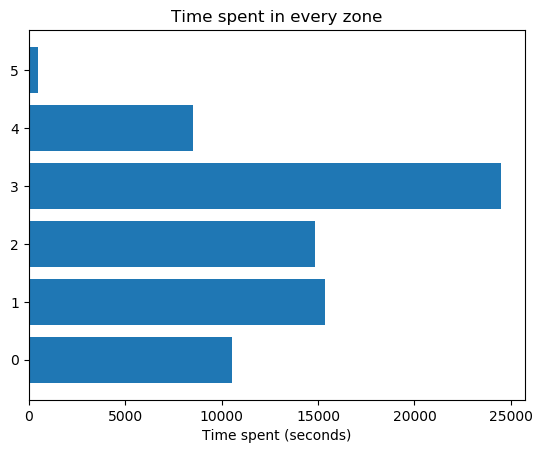

In [100]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

zones=[]
for i in time_in_zone:
    zones=zones+[i[0]]

y_pos = np.arange(len(zones))

time_spent=[]
for i in time_in_zone:
    time_spent=time_spent+[i[1]]
    
plt.barh(y_pos, time_spent, align='center', alpha=1)
plt.yticks(y_pos, zones)
plt.xlabel('Time spent (seconds)')
plt.title('Time spent in every zone')

plt.show()

In [66]:
# an alternative visualization 
conn = create_connection(db_file, delete_db=False)
sql='select zone, count(*) as duration from activities_base_with_zone group by 1;'
zone_duration=pd.read_sql(sql,conn)
pd.read_sql(sql,conn)

,zone,duration
0,0,10545
1,1,15385
2,2,14858
3,3,24482
4,4,8499
5,5,478


In [112]:
Zones=zone_duration['zone'].to_numpy()
Duration=zone_duration['duration'].to_numpy()
series = pd.Series(Duration, index=Zones, name='Time spent on every zone')
# series.plot.pie(figsize=(10, 10),startangle=90, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)

# 5. Percentage duration spent in every zone

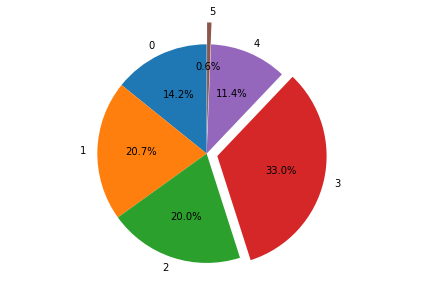

In [86]:
import matplotlib.pyplot as plt
explode=(0,0,0,0.1,0,0.2)
fig1,ax1=plt.subplots()
ax1.pie(Duration,explode=explode,labels=Zones,autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.show()

# 6. Is elevation gain directly related to Heartrate increase?


In [110]:
filenames=['Running_18-34-29.csv']

listdf=[]
timeintervals=[]
for filename in filenames:    
    activity="""'"""+filename+"""'"""
    prevelevation=0
    prevheartrate=0
    elevationchange=[]
    heartratechange=[]
    for k in range(30,91,30):
        for i in range(1,2000,k):
            sql1="""select elevation , heartrate from activities_base where activity_id= %s order by time asc LIMIT %s"""%(activity,i)
            conn = create_connection(db_file, delete_db=False)
            cur=conn.cursor()
            row=cur.execute(sql1).fetchall().pop()
            elevationchange.append(abs(row[0]-prevelevation))
            heartratechange.append(abs(row[1]-prevheartrate))
            prevelevation=row[0]
            prevheartrate=row[1]
        elevationchange=elevationchange[1:]
        heartratechange=heartratechange[1:]
        df = pd.DataFrame(list(zip(elevationchange, heartratechange)), columns =['Elevation Gain', 'Heartrate increase']) 
        listdf.append(df)
    timeintervals.append(k)

elevation_hr=listdf[0]


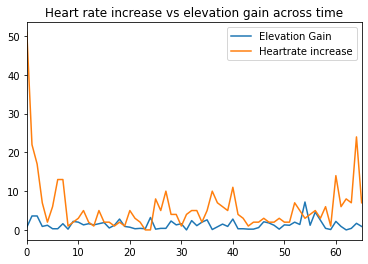

In [111]:
lines = elevation_hr.plot(title='Heart rate increase vs elevation gain across time')